### Data Representation in Knowledge Graph

A knowledge graph is a method of storing data that results from the process of extracting information. A common way of implementing knowledge graphs is through the use of "triples," which are sets of three elements (a subject, a predicate, and an object) used to store information about a specific topic. Knowledge graphs can take various forms and sizes.

In terms of data representation, a sentence like "London is the capital of England. Westminster is located in London" can be transformed into two triples: (London, be capital, England) and (Westminster, locate, London). This example shows how a knowledge graph is made up of unique entities (London, England, Westminster) and relations (be capital, locate) between them, represented as nodes and edges.

Manually building a knowledge graph can be overwhelming due to the large amount of data. That's why machines are better suited for this task, as they can easily process hundreds or thousands of documents. However, machines do not understand natural language, which is where Natural Language Processing (NLP) comes in. NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition are used to help machines understand and extract information from natural language text.

1.1 Import Dependencies & Load dataset

In [7]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [13]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("./data/wiki_sentences_v2.csv", on_bad_lines='skip')
candidate_sentences.shape

(4318, 1)

In [14]:
candidate_sentences['sentence'].sample(5)

2219                              coraline was theatrically released on february 6, 2009.
654     the film is duplicated as required  and distributed to cinemas for exhibition .  
163                                      pre-production had begun by early december 2017.
932     film capacitors are subject to certain very small but measurable aging processes.
2648                                the mystery begins , was released by cartoon network.
Name: sentence, dtype: object

1.2 Sentence Segmentation

The initial stage in constructing a knowledge graph involves separating the text document or article into individual sentences. Following this, we will select only those sentences that contain one subject and one object.

In [15]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... amod
standard ... compound
d823 ... pobj


1.3 Entities Extraction

Extracting a single word entity from a sentence is not difficult. We can accomplish this by utilizing parts of speech (POS) tags. In this process, nouns and proper nouns are identified as entities.
However, when an entity is made up of multiple words, POS tags alone are not sufficient. In such cases, we need to analyze the dependency tree of the sentence.

The key components of building a knowledge graph are the nodes and the connections between them. These nodes are entities present in Wikipedia sentences and the edges represent the relationships between these entities. We extract these elements in an unsupervised manner by utilizing the grammar of the sentences.

The basic concept is to go through a sentence and extract the subject and the object as they are encountered. However, there are certain challenges - an entity can span multiple words, such as "red wine", and dependency parsers only tag individual words as subjects or objects.

To address these challenges, I have created a function that extracts the subject and the object (entities) from a sentence. The code has been broken down into multiple sections for ease of understanding.

In [17]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
  return [ent1.strip(), ent2.strip()]

In [18]:
get_entities("the film had 200 patents")


['film', '200  patents']

In [19]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:37<00:00, 113.92it/s]


In [20]:
entity_pairs[10:20]


[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

1.4 Relations Extraction

Extracting entities is only half the work. To create a knowledge graph, we also need relationships, or edges, to connect the entities, or nodes. Our assumption is that the predicate, which is the main verb in a sentence, is the key component of a relationship.  

The function below, which uses spaCy's rule-based matching, is able to capture such predicates from sentences.

In [24]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [25]:
get_relation("John completed the task")

'completed'

In [26]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:39<00:00, 110.25it/s]


In [27]:
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

1.5 Build Knowledge Graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [28]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

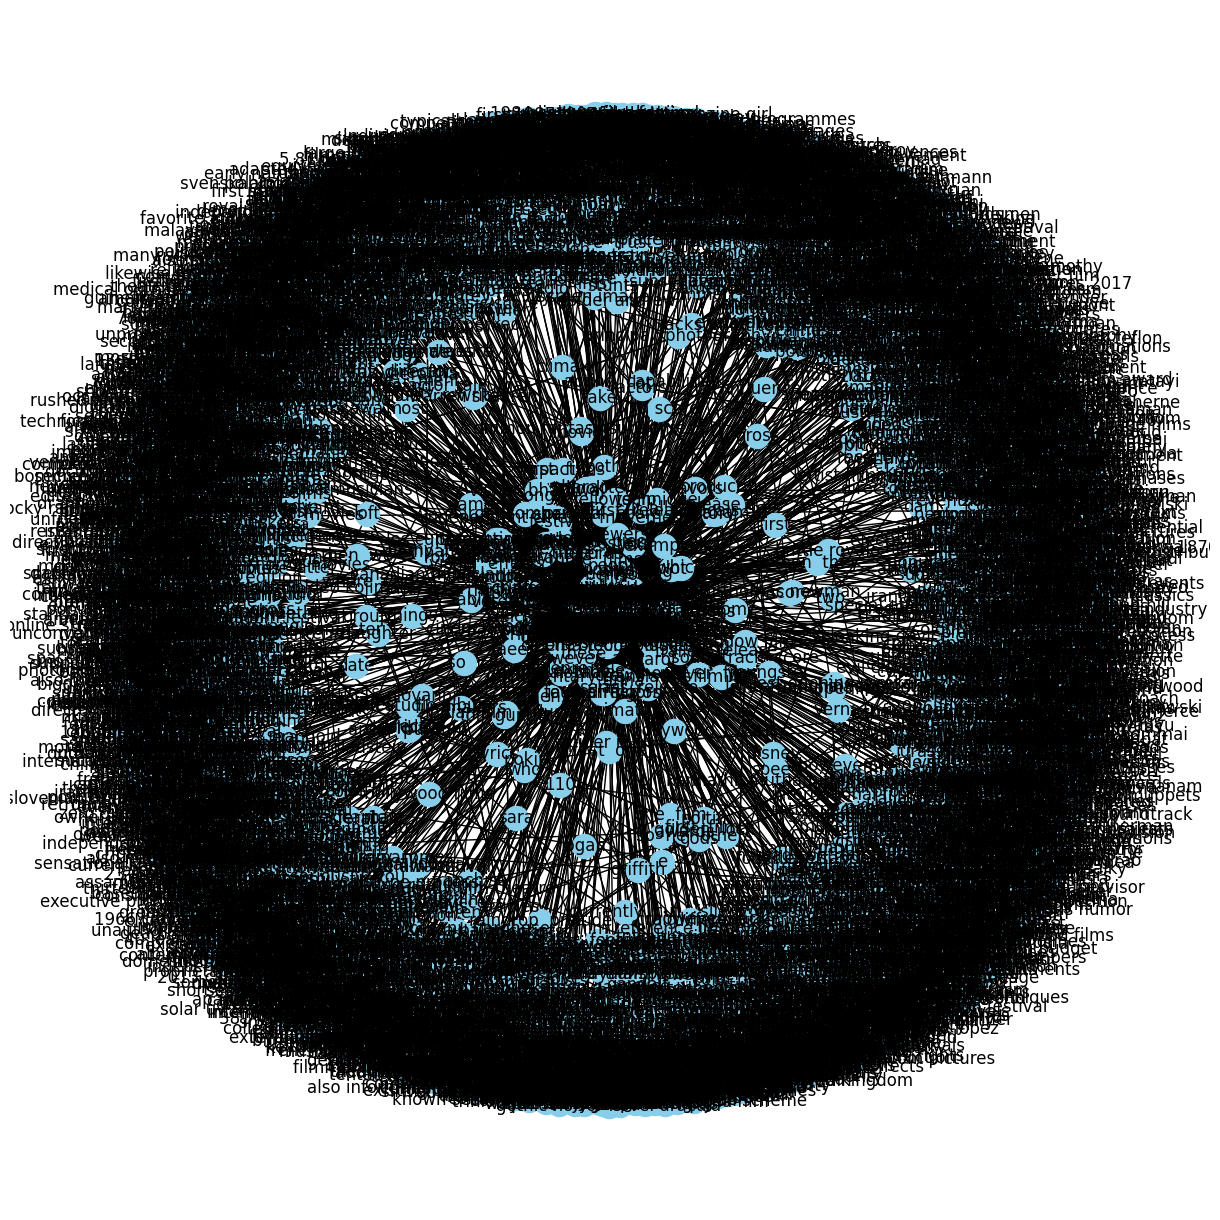

In [30]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

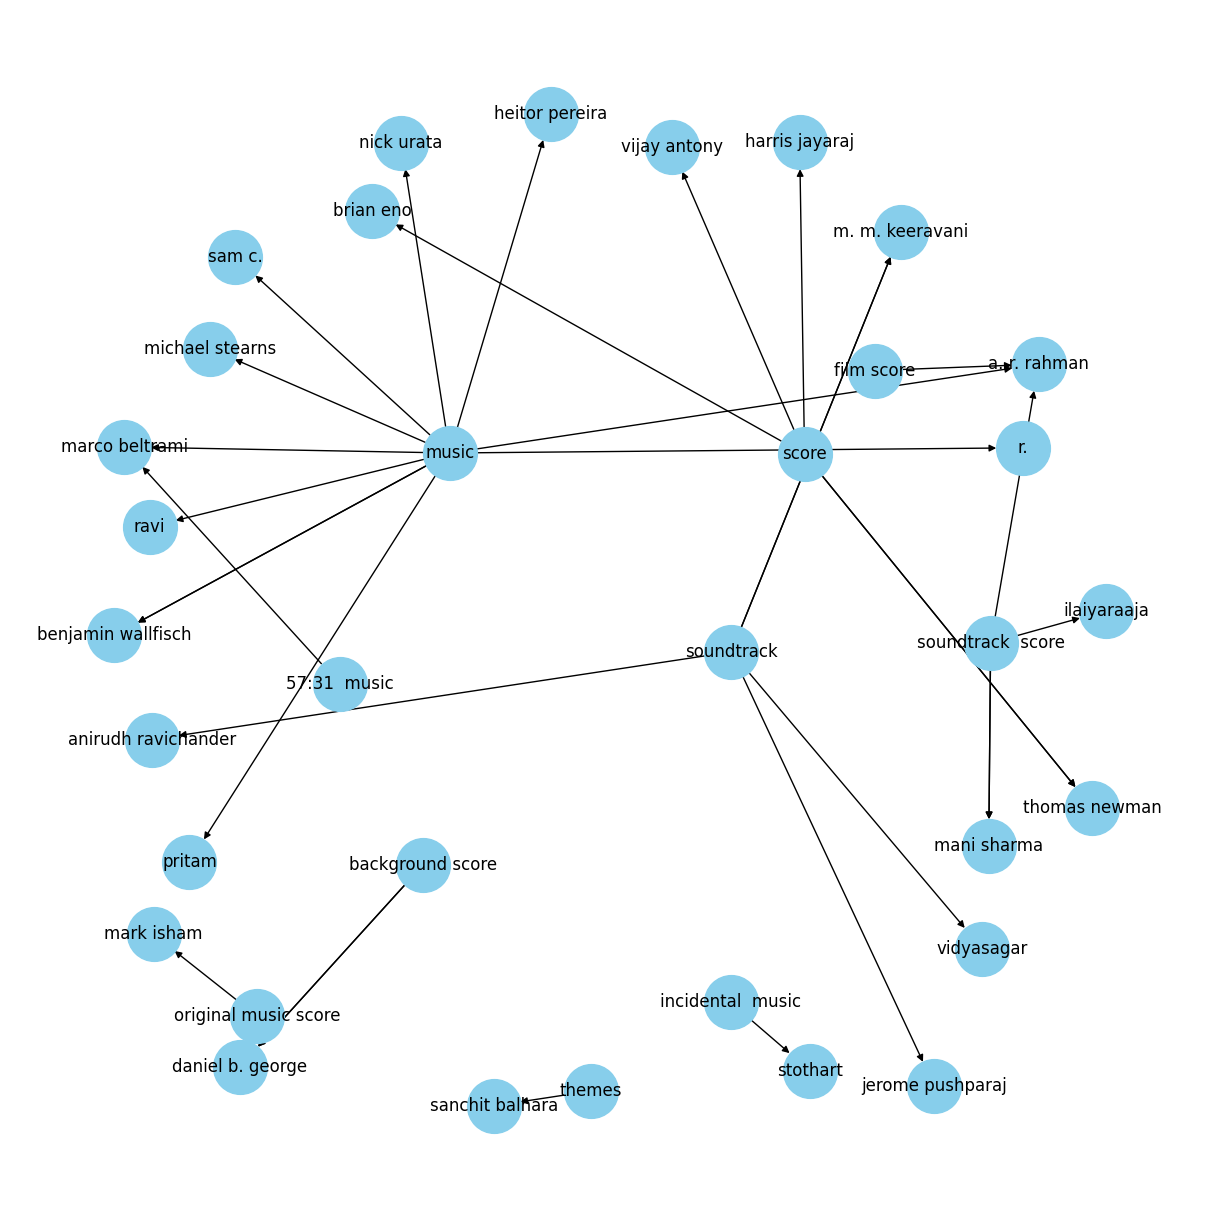

In [31]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

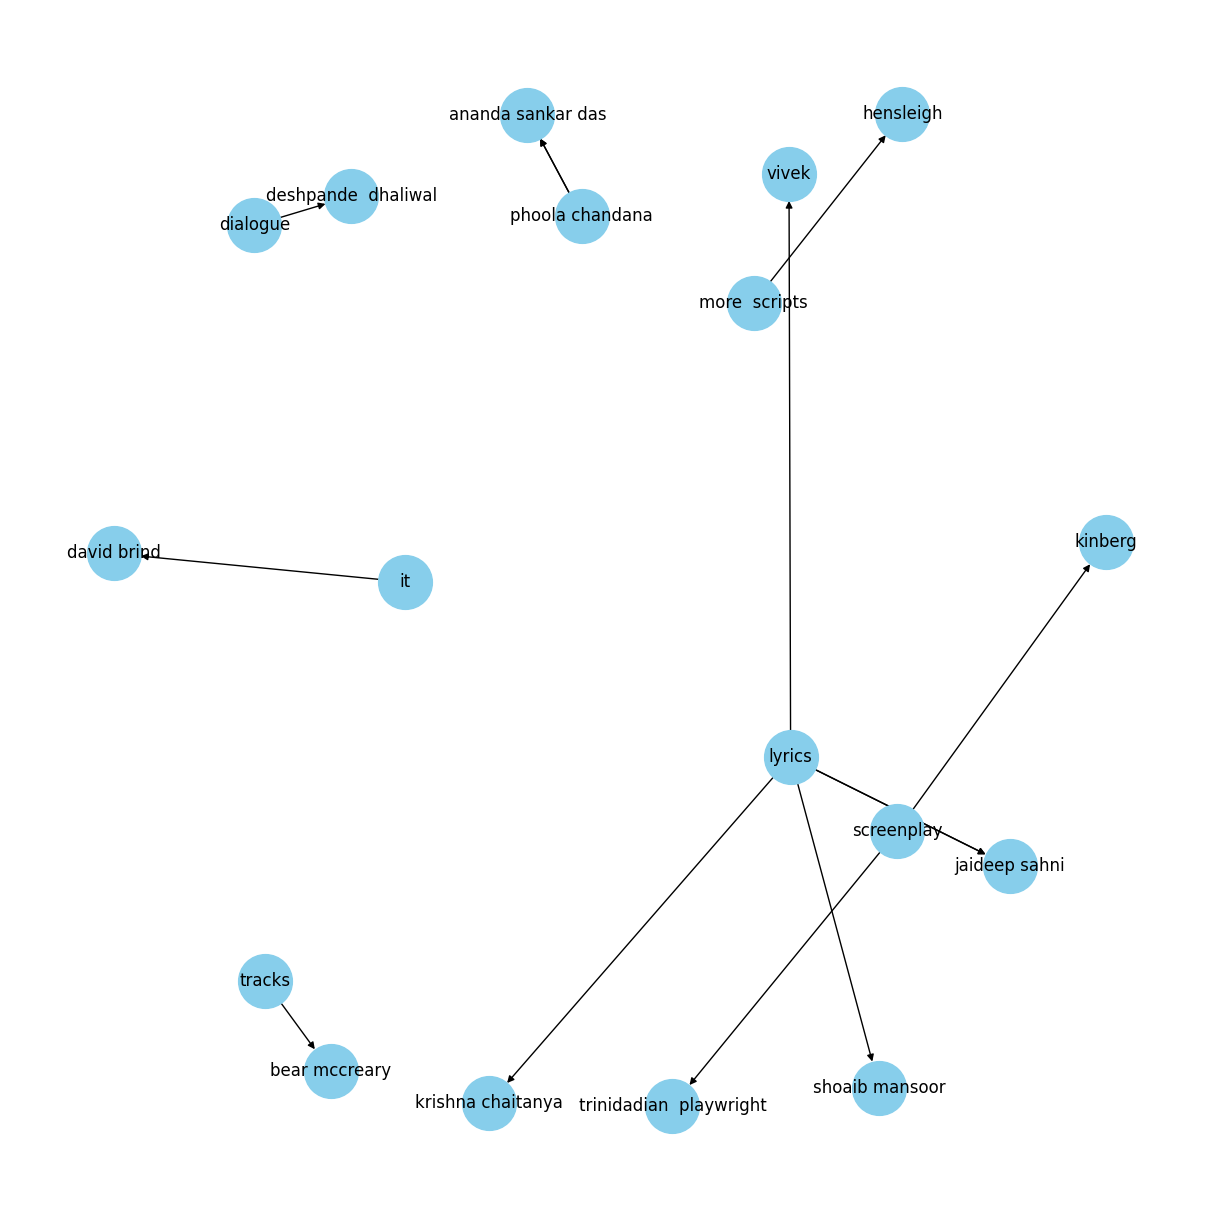

In [32]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

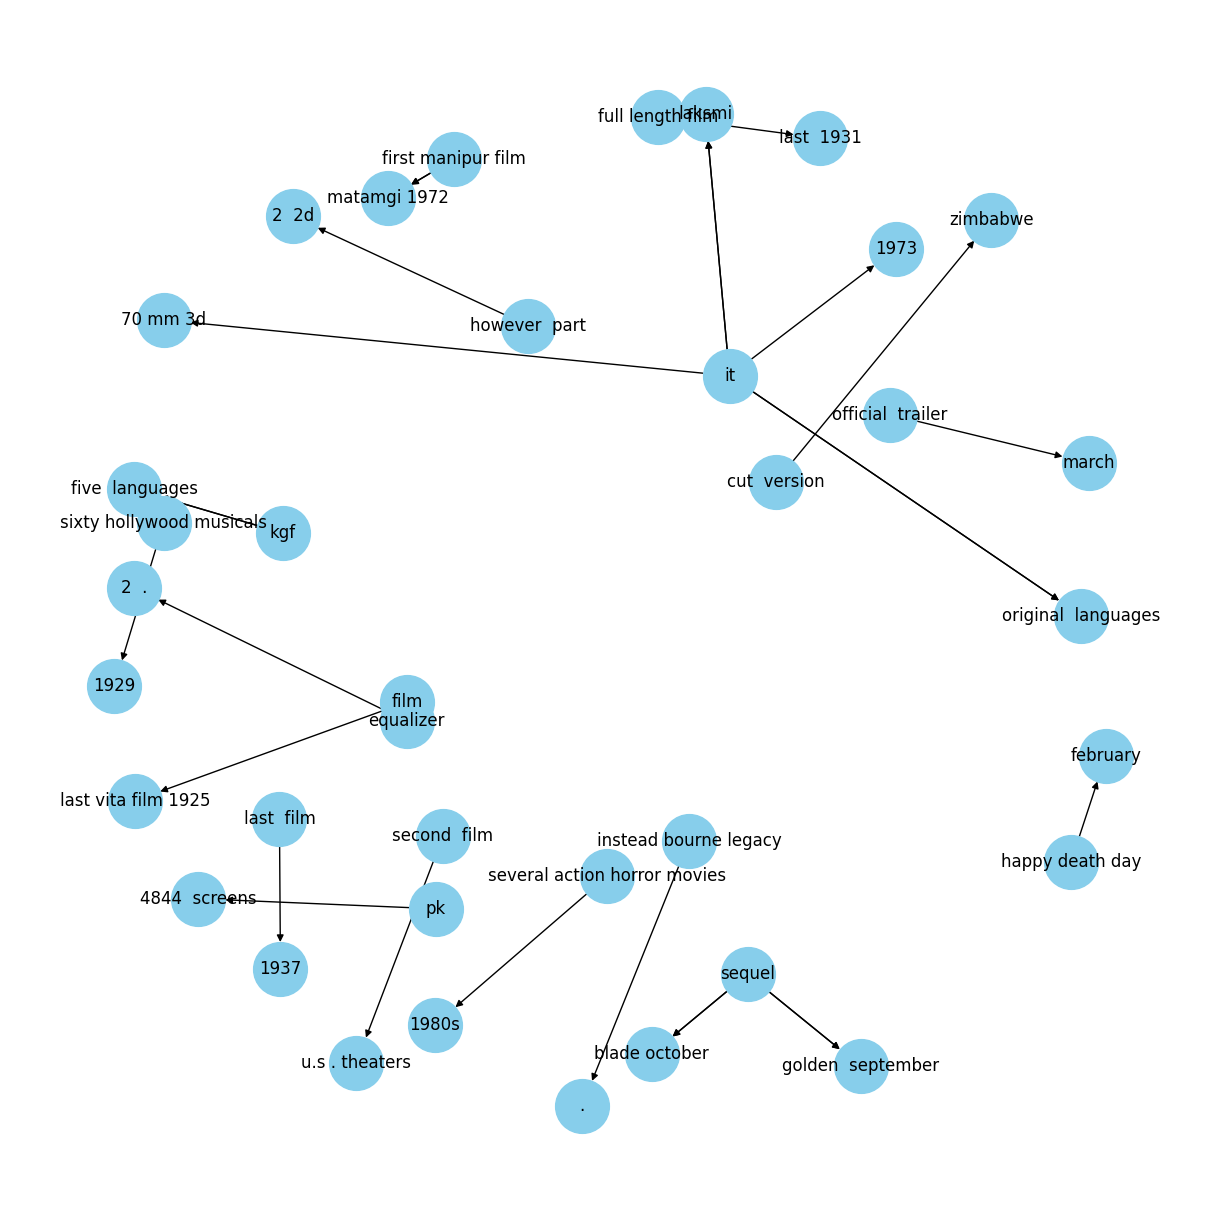

In [33]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

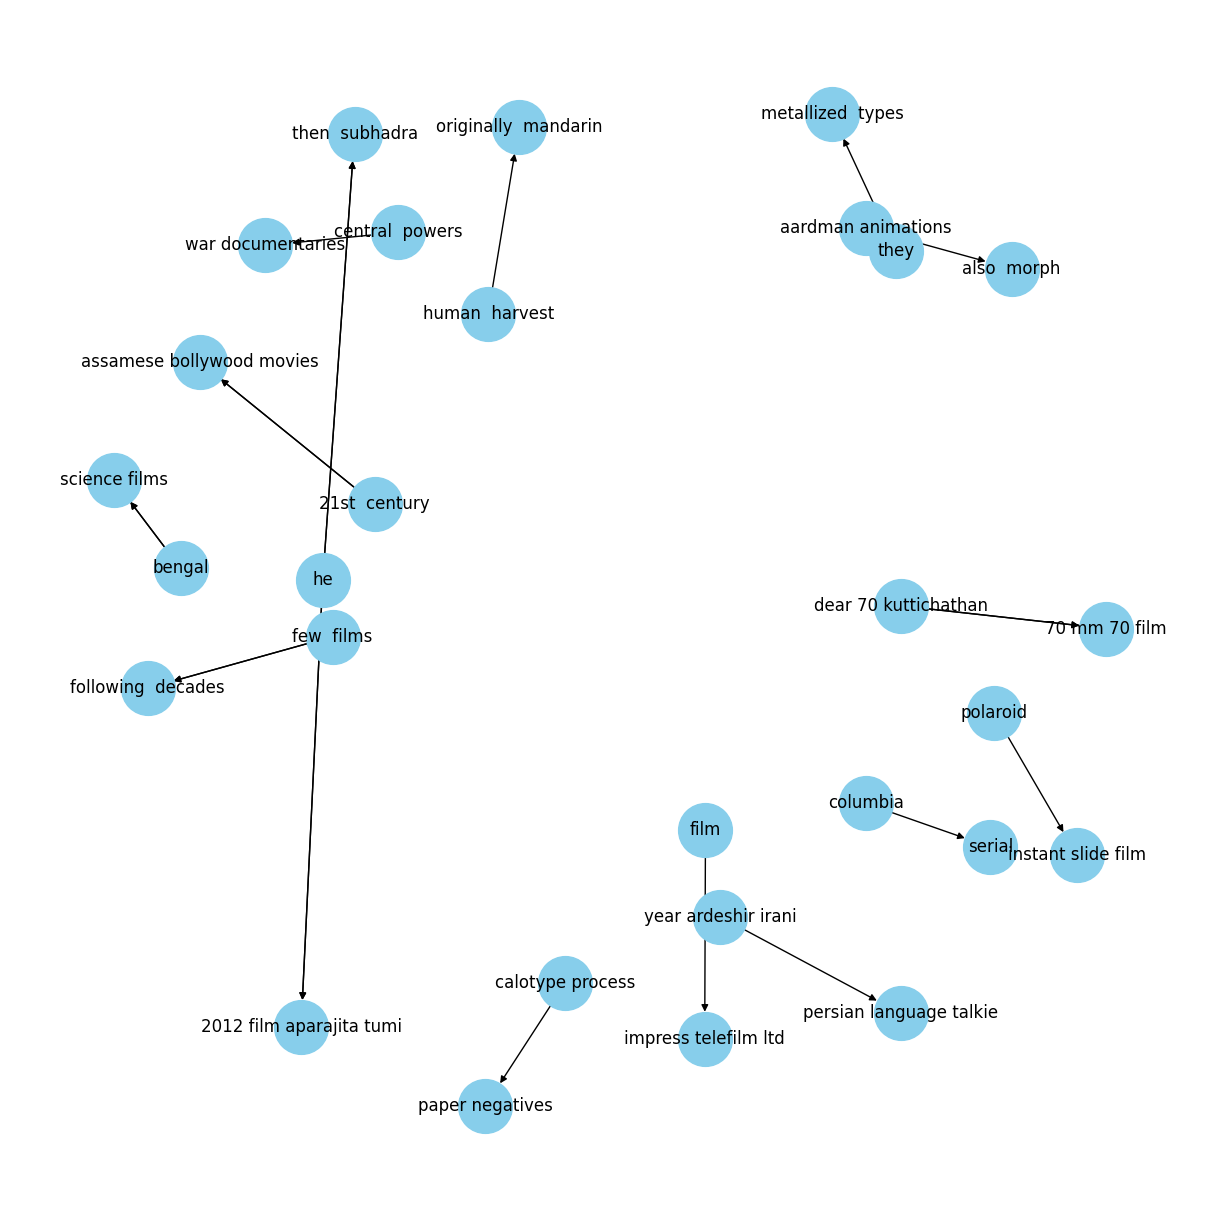

In [34]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="produced"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

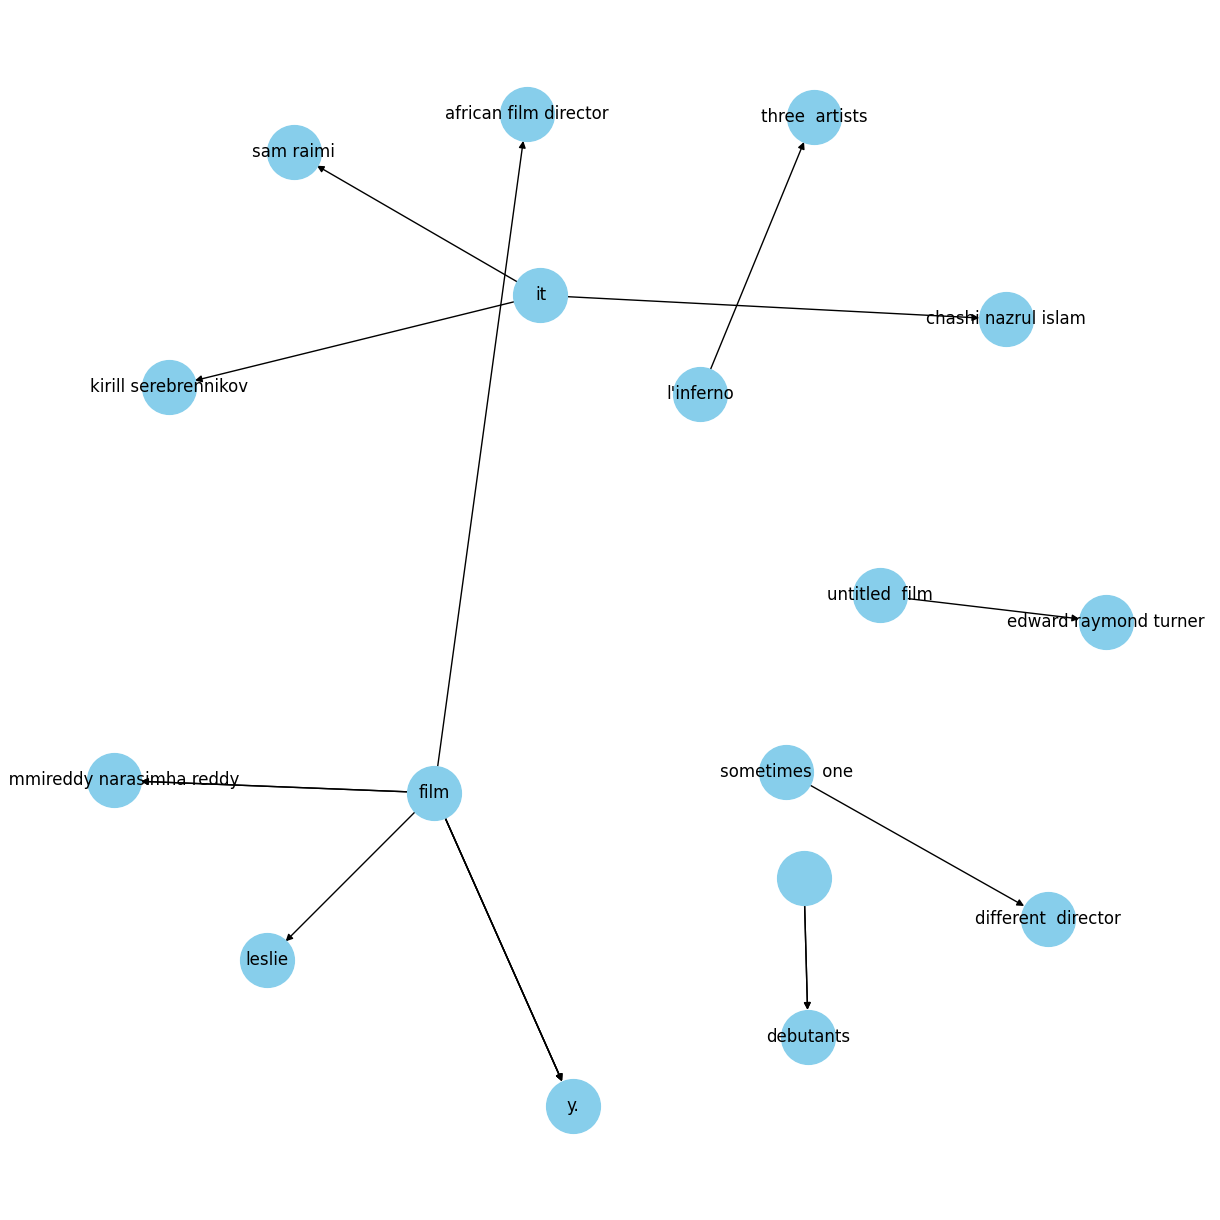

In [35]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="directed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()